# 量子核方法

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

在量子机器学习中，参数化量子电路（parameterized quantum circuit）扮演着重要的角色。在很多场景中，为了类比经典机器学习领域中的神经网络方法，我们也经常会把参数化量子电路称为量子神经网络。但是实际上，在量子机器学习的相关应用中，人们发现参数化量子电路的数学原理更类似于经典机器学习中的核方法（kernel methods）[1]。这种通过将量子计算和经典核方法相结合的思路以及研究方法，就被称为量子核方法（quantum kernel methods）。这两种方法的结合对于量子计算如何更好的解决一系列机器学习问题提供了全新的视角，因此在近年来收到了极大的关注 [2-7]。在本教程中，我们将探究如何用量子核方法结合支持向量机来实现数据分类。

### 理论背景

在经典机器学习中，核方法一般指的是将低维的数据向量通过特征映射（feature map）映射到高维的特征空间（feature space）中，来识别低维数据中难以分辨的模式的方法。如图1的例子所示，通过将一维的线性不可分数据映射到二维，映射后的数据在二维空间中是线性可分的。

![feature map](./figures/Qkernel-fig-featuremap.png "图1：核方法中的特征映射")
<div style="text-align:center">图1：核方法中的特征映射 </div>

不过，在实际应用中，由于特征空间的维数可能会十分巨大，我们往往并不希望直接对映射后的特征向量进行分析。相反，通过核方法中的另一个核心概念-核函数（kernel function），我们可以隐式地引入特征映射在模式识别上的优势。核函数的定义为数据向量在特征空间里的内积，其具体形式为

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_j)^T \phi(\mathbf{x}_i),
\tag{1}
$$

其中 $\phi()$ 就代表着特征映射。需要注意的是，在核方法中我们并不需要显式地写出特征映射，而只需要定义核函数的形式即可。

在经典机器学习中，核方法最具代表性的应用就是支持向量机（support vector machine, SVM）。简单的来说，支持向量机解决的是线性分类问题：以一个二分类的问题举例，我们的数据集为 $T = \{ (\mathbf{x}_1, y_1), ..., (\mathbf{x}_m, y_m) \} \subset \mathcal{X}\times\mathbb{Z}_2$，通过一个超平面 $(\mathbf{w}, b)$，支持向量机可以通过如下决策函数的正负来预测每个数据点 $\mathbf{x}$ 的标签：

$$
y_{\rm pred} = {\rm sign}(\langle \mathbf{w}, \mathbf{x} \rangle + b).
\tag{2}
$$

但是对于在原始数据空间中线性不可分的数据而言，这样的做法往往并不可行。所以如图1所示，通过引入我们上文中提到的特征映射，我们可以将原始数据空间中的数据向量映射到特征空间中来进行分类，从而得到更好的分类效果。此时，我们标记特征空间中的超平面为 $(\mathbf{w}', b')$, 我们的决策函数就变成了：

$$
y_{\rm pred} = {\rm sign}(\langle \mathbf{w}', \phi(\mathbf{x}) \rangle + b').
\tag{3}
$$

更进一步的是，我们可以通过对偶化的方法，引入拉格朗日乘子 $\alpha_i$ 来表示此时的分割超平面 $\mathbf{w}' = \sum_i \alpha_i \phi(\mathbf{x_i})$ [8]。此时，我们可以在 $\alpha_i \geq 0$，$\sum_i y_i \alpha_i=0$ 的约束下，通过最大化

$$
\sum_i \alpha_i - \frac{1}{2} \sum_{i, j} \alpha_i \alpha_j y_i y_j \phi(\mathbf{x}_j)^T \phi(\mathbf{x}_i)
\tag{4}
$$

来计算最优参数 $\alpha_i^*$。不难发现，此时我们只需要计算数据向量在特征空间里的内积 $\phi(\mathbf{x}_j)^T \phi(\mathbf{x}_i) = K(x_i, x_j)$，正是我们上文中提到的核函数。换言之，在支持向量机中，我们不需要显式地知道特征映射的形式，而只需要计算原始数据在特征空间里的内积，就可以实现在特征空间中对数据进行分类。并且，对于任何新的数据向量 $\mathbf{x}'$，我们只需要通过核函数 $K(,)$ 计算

$$
y_{\rm pred} = {\rm sign}(\sum_i \alpha^*_i  \langle \phi(\mathbf{x_i}), \phi(\mathbf{x}' \rangle + b') = 
{\rm sign}(\sum_i \alpha^*_i  K(\mathbf{x}_i, \mathbf{x}') + b'),
\tag{5}
$$

就可以对数据的标签进行预测。

借助这种思想，我们就可以很简单的理解量子核方法的内涵。首先，我们引入量子特征空间的概念，即我们认为我们通过一个编码电路 $U(\mathbf{x}) $ 将经典数据向量 $\mathbf{x} $ 编码到某个量子态 $| \phi(\mathbf{x}) \rangle$ 上：

$$
U(\mathbf{x}) | 0^{\otimes N} \rangle = | \phi(\mathbf{x}) \rangle.
\tag{6}
$$ 

关于编码电路的具体形式我们这里不做展开，感兴趣的读者可以阅读我们的[编码教程](./DataEncoding_CN.ipynb)来了解不同的量子编码电路形式。此时我们的量子特征映射就是从经典数据空间到量子态所处的希尔伯特空间的一种特殊特征映射。在这个基础上，我们将量子核函数（quantum kernel function）定义为经典数据向量在量子特征空间的内积，其具体形式就为

$$
K^Q_{ij} = |\langle \phi(\mathbf{x}_j) | \phi(\mathbf{x}_i) \rangle |^2,
\tag{7}
$$

上式可以进一步写为

$$
|\langle \phi(\mathbf{x}_j) | \phi(\mathbf{x}_i) \rangle |^2 =  |\langle 0^{\otimes N} | U^\dagger(\mathbf{x}_j) U(\mathbf{x}_i) | 0^{\otimes N} \rangle |^2.
\tag{8}
$$

不难发现，通过运行如图2中所示的量子电路，并在统计其测量结果为 $| 0^{\otimes N} \rangle $ 的概率，我们就可以估计式（8）中的量子核函数。这种方法也被称为量子核估计（quantum kernel estimation, QKE）方法。也就是说，如果我们通过量子核估计方法来计算式（4-5) 中的核函数的话，我们就可以利用支持向量机的方法在量子特征空间来完成数据分类。借助量子特征映射的量子性，人们希望这种量子核方法可以更好地分类具有复杂模式的数据。人们已经证明，通过精心设计量子特征映射，量子核方法就可以用来分辨任何经典方法都无法识别的数据模式 [3]。

![QKE](./figures/Qkernel-fig-QKE.png "图2：量子核估计电路")
<div style="text-align:center">图2：量子核估计电路 </div>

![illustration](./figures/Qkernel-fig-illustrationCN.png "图3：经典核方法和量子核方法的对比示意图")
<div style="text-align:center">图3：经典核方法和量子核方法的对比示意图 </div>

### 拓展：量子机器学习和核方法的联系

在量子机器学习中，往往我们量子电路中的一部分需要将经典的数据编码到其对应的量子态上，其数学形式为：

$$
| \phi(x) \rangle = U (x) | 0^{\otimes N} \rangle,
\tag{9}
$$

其中 $U(x)$ 是一个取决于经典数据 $x$ 的参数化电路。正如我们上文中提到的，这种编码的过程可以被考虑成是一种从经典数据空间到量子特征空间的特殊特征映射。同时，考虑一个作用在编码量子态上的量子神经网络电路，其数学形式为：

$$
| \psi \rangle = U_{\rm QNN}(\theta)U (\mathbf{x}) | 0^{\otimes N} \rangle,
\tag{10}
$$

其中 $U_{\rm QNN}(\theta)$ 为代表量子神经网络的参数化量子电路，$\theta$ 为其中的参数。我们在电路的最后进行测量，该测量用 $\mathcal{M}$ 表示。这时，我们测得的期望值为

$$
\langle \mathcal{M} \rangle = \langle \psi | \mathcal{M} | \psi \rangle = \langle \phi(\mathbf{x}) | U^\dagger_{\rm QNN}(\theta) \mathcal{M} U_{\rm QNN}(\theta)| \phi(\mathbf{x}) \rangle.
\tag{11}
$$

我们不妨将测量写成算符的形式 $| \sigma \rangle \langle \sigma |$ ，那么式（11）就可以进一步被写为

$$
\langle \phi(\mathbf{x}) | \sigma'(\theta) \rangle \langle \sigma' (\theta)  | \phi(x) \rangle = 
|\langle \sigma' (\theta)  | \phi(\mathbf{x}) \rangle|^2,
\tag{12}
$$

其中 $| \sigma'(\theta) \rangle = U^\dagger_{\rm QNN}(\theta) | \sigma \rangle$。这样的话，我们发现我们这种基于量子神经网络的测量结果也可以被认为是量子特征空间中两个量子特征向量的内积：$|\langle \sigma' (\theta)  | \phi(\mathbf{x}) \rangle|^2$。
而该内积，正是我们前文中提到的量子核函数，只不过其中一个特征向量是由一个参数化的测量所描述的。这也就是我们在本教程的一开始提到，量子神经网络模型的数学形式实际上更接近于经典机器学习中的核方法的原因。

## 示例：利用量子核方法来解决分类问题

> 本教程需要使用 [`sklearn`](https://scikit-learn.org/stable/install.html) 中的相关函数来实现支持向量机的功能。需要的读者可以运行下面的代码块来安装相关模块：

In [1]:
from IPython.display import clear_output

!pip install scikit-learn
clear_output()

下面，我们用一个简单的例子来展示如何在 Paddle Quantum 中模拟量子核估计电路，并将其应用在一个实际的分类任务上。

In [3]:
import time
import matplotlib
import numpy as np
import paddle
from numpy import pi as PI
from matplotlib import pyplot as plt

from paddle import matmul, transpose
from paddle_quantum.ansatz import Circuit
from paddle_quantum.gate import IQPEncoding
import paddle_quantum

import sklearn
from sklearn import svm
from sklearn.datasets import fetch_openml, make_moons, make_circles
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from tqdm import tqdm

首先，我们生成两类线性不可分的二维圆形数据点作为我们的训练集和测试集。

先来看一下我们的训练集和测试集:


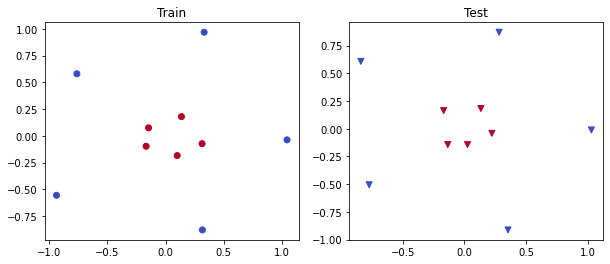

In [4]:
# 生成训练集和测试集
X_train, y_train = make_circles(10, noise=0.05, factor=0.2, random_state=0)
X_test, y_test = make_circles(10, noise=0.05, factor=0.2, random_state=1024)

# 将生成的数据集进行可视化
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], 
              marker='o', c = matplotlib.cm.coolwarm(np.array(y_train, dtype=np.float32)))
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', c = matplotlib.cm.coolwarm(np.array(y_test, dtype=np.float32)))

print("先来看一下我们的训练集和测试集:")

In [5]:
# 初始化进度条
bar_format_string = '{l_bar}{bar}|[{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]'
pbar = tqdm(total=100, bar_format=bar_format_string)
pbar.close()
clear_output()

下面，我们来用 PaddleQuantum 来搭建量子核函数的计算电路：

In [7]:
# 初始化一个用来更新进度条的全局变量
N = 1

# 通过 paddle quantum 模拟的 QKE 电路
def q_kernel_estimator(x1, x2):
    
    # 将数据类型转换为 tensor
    x1 = paddle.to_tensor(x1)
    x2 = paddle.to_tensor(x2)
    
    # 创建电路
    cir = paddle_quantum.ansatz.Sequential()
    
    # 添加对应第一个数据的编码电路
    cir.append(IQPEncoding(qubits_idx=[[0,1]], feature=x1))
    init_state = paddle_quantum.state.zero_state(2)
    state = cir[0](state=init_state)
    
    # 添加对应第二个数据的编码电路的逆电路
    cir.append(IQPEncoding(qubits_idx=[[0,1]], feature=x2))
    fin_state = cir[1](state=state,invert=True).data
    
    # 更新进度条
    global pbar
    global N
    pbar.update(100/N)

    # 返回测量结果为 0...0 的概率
    return (fin_state[0].conj() * fin_state[0]).real().numpy()[0]

# 按照规范定义需要传入的 Kernel 矩阵函数
# 按照规范，输入应为两个数据列表
def q_kernel_matrix(X1, X2):
    return np.array([[q_kernel_estimator(x1, x2) for x2 in X2] for x1 in X1])

# 可视化决策函数（预测值），以及决策边界
def visualize_decision_bound(clf):
    
    # 创建一个 10x10 的网格
    x_min, x_max = X_train[:,0].min(), X_train[:,0].max()
    y_min, y_max = X_train[:,1].min(), X_train[:,1].max()
    XX, YY = np.meshgrid(np.linspace(-1.2, 1.2, 10), 
                         np.linspace(-1.2, 1.2, 10))
    
    # 计算分类器该网格上的预测值
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z_qke = Z.reshape(XX.shape)
    
    # 可视化决策函数，以及决策边界
    clear_output()
    plt.contourf(XX, YY, Z_qke ,vmin=-1., vmax=1., levels=20,
                 cmap=matplotlib.cm.coolwarm, alpha=1)
    plt.scatter(X_train[:,0], X_train[:,1], 
                c = matplotlib.cm.coolwarm(np.array(y_train, dtype=np.float32)),
               edgecolor='black')
    plt.scatter(X_test[:,0], X_test[:,1], marker='v', 
                c = matplotlib.cm.coolwarm(np.array(y_test, dtype=np.float32)),
               edgecolor='black')
    plt.contour(XX, YY, Z_qke, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.2, 0, .2])

# 作为检查量子核函数是否运行正常，我们可以检查 K(x, x) 是否等于 1
# 提示：根据内积的定义 <x, x> = 1
print('检查是否满足 K(x, x) = 1？',
      bool(abs(q_kernel_estimator(np.array([1. ,1.]), np.array([1., 1.])) - 1) < 1e-6))

检查是否满足 K(x, x) = 1？ True


接下来，让我们尝试用量子核支持向量机（QKE-SVM）来进行数据分类：

让我们看一下量子核支持向量机的分类效果如何:


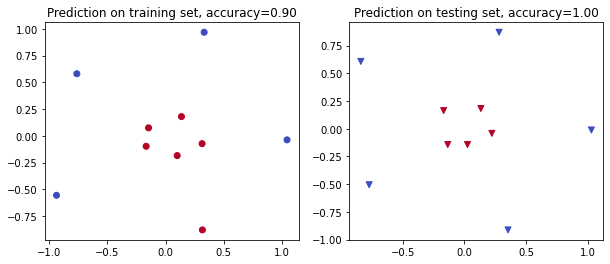

In [8]:
# 创建进度条，并设置所需要的量子核函数计算数量 N
pbar = tqdm(total=100, 
            desc='训练 QKE-SVM 并分类中', 
            bar_format=bar_format_string)
N = len(X_train) ** 2 + len(X_train) ** 2 + len(X_train) * len(X_test)

# 创建一个具有量子核函数的支持向量机
svm_qke = svm.SVC(kernel=q_kernel_matrix)

# 根据训练数据计算支持向量机的决策平面
svm_qke.fit(X_train, y_train)

# 计算支持向量机分别对于训练数据和测试数据的分类预测值
predict_svm_qke_train = svm_qke.predict(X_train)
predict_svm_qke_test = svm_qke.predict(X_test)

# 计算准确率
accuracy_train = np.array(predict_svm_qke_train == y_train, dtype=int).sum()/len(y_train)
accuracy_test = np.array(predict_svm_qke_test == y_test, dtype=int).sum()/len(y_test)

# 可视化分类预测结果
pbar.close()
clear_output()
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], marker='o', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_qke_train, dtype=np.float32)))
ax[0].set_title('Prediction on training set, accuracy={:.2f}'.format(accuracy_train))
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_qke_test, dtype=np.float32)))
ax[1].set_title('Prediction on testing set, accuracy={:.2f}'.format(accuracy_test))
print("让我们看一下量子核支持向量机的分类效果如何:")

更进一步的，我们还可以检查此时的决策函数平面以及决策边界：

计算 QKE-SVM 的决策函数中: 100%|█████████████████████████████████████████████████▉|[00:09<00:00, 10.09it/s]


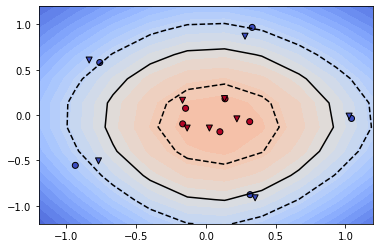

In [9]:
# 创建进度条，并设置所需要的量子核函数计算数量 N
pbar = tqdm(total=100, 
            desc='计算 QKE-SVM 的决策函数中', 
            bar_format=bar_format_string)
N = 10 ** 2 * len(X_train)
    
# 可视化决策函数平面
visualize_decision_bound(svm_qke)
pbar.close()

可以看到，量子核函数可以很好的学习到数据中的非线性特征。实际上，量子核方法的表现取决于量子特征映射的设计。并且，对于如何设计更好的量子核函数的探究才刚刚开始：一方面，我们可以尝试不同的数据编码方式；另一方面，我们可以尝试通过训练量子特征映射的方式提升分类效果 [5-6]；最后，我们还可以尝试一些不同的量子核函数形式 [7]。

下面，作为拓展，我们也将展示一种特殊的量子核函数:投影量子核函数（projected quantum kernel）。

### 拓展：投影量子核函数

上文中已经提到，量子核方法通过将经典信息映射到潜在的高维量子特征空间来分辨在经典空间不可分的信息。但是，当我们的量子特征空间-希尔伯特空间的维度太大的时候，所有映射到希尔伯特空间的量子态都会接近于相互垂直的状态，此时的核矩阵将会近似的变成一个单位矩阵 $K_{ij} = K(\mathbf{x}_j, \mathbf{x}_i) \sim {I}$。为了避免这种维度问题的出现，我们需要首先从高维希尔伯特空间提取出足够的低维信息。投影量子核方法就是遵循了这个思路，即将量子态投影到新的经典空间，再在这个新的经典空间使用核方法。我们可以认为每一个投影是从不同的角度去观测希尔伯特空间的量子态，从足够多的角度测量这个量子态可以使我们获得足够重构这个态的经典信息。但在实际应用中，通常只需要从几个角度测量就能得到比较好的结果 [5]。 由于这个经典空间保留了部分希尔伯特空间中的重要特征，所以信息在这个经典空间的可分性优于原来的经典空间。

投影量子核函数有很多不同的形式，这里我们举一个最为代表性的作为例子：

$$
K^{PQ}(x_i,x_j) = \exp\left(-\gamma\sum\limits_{k}\sum\limits_{P\in \mathcal{M}}( {\rm Tr} (P\rho(x_i)_k)-{\rm Tr}(P\rho(x_j)_k))^{2}\right),
\tag{13}
$$

其中 $k$ 是用来标记多量子比特约化密度矩阵的下标，$\mathcal{M}$ 是一个作用在多量子比特约化密度矩阵上的测量的集合。在这里，我们取 $k = 0, 1$，即两个单量子比特的约化密度矩阵，$M = \{X, Y, Z \}$，即一组 Pauli 测量。

我们先尝试用 Paddle Quantum 来实现对应的投影量子核电路：

In [10]:
# 因为这次我们的特征映射的特征空间也是经典的，我们不妨先把该映射写出来
def projected_q_feature_map(x):
    # 将经典数据转换为 Tensor
    x = paddle.to_tensor(x)
    
    # 更新进度条
    global N
    pbar.update(100/N)
    
    init_state = paddle_quantum.state.zero_state(2)

    # 进行投影测量，返回其期望值作为经典特征向量
    res = []
    for op_pauli in ['z0', 'z1', 'x0', 'x1', 'y0', 'y1']:
        cir = paddle_quantum.ansatz.Sequential()
        cir.append(IQPEncoding(qubits_idx=[[0, 1]], feature=x))
        state = cir[0](init_state)
        hamiltonian = paddle_quantum.Hamiltonian([[1.0, op_pauli]])
        cir.append(paddle_quantum.loss.ExpecVal(hamiltonian))
        res.append(cir[1](state).numpy()[0])
    return res

# 按照上文公式计算投影量子核函数
def p_quantum_kernel_estimator(x1, x2):
    
    # 分别得到特征向量，并计算核函数
    p_feature_vector_1 = np.array(projected_q_feature_map(x1))
    p_feature_vector_2 = np.array(projected_q_feature_map(x2))
    
    return np.exp(-((p_feature_vector_1 - p_feature_vector_2) ** 2).sum())

# 类似地，按照规范定义传入支持向量机的核函数
def p_quantum_kernel_matrix(X1, X2):
    return np.array([[p_quantum_kernel_estimator(x1, x2) for x2 in X2] for x1 in X1])

接下来，让我们看一下如何用投影量子核支持向量机（PQK-SVM）来进行数据分类：

让我们看一下投影量子核支持向量机的分类效果如何:


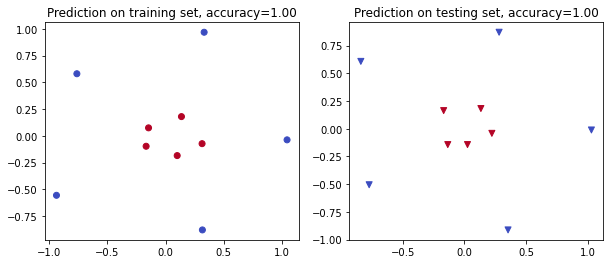

In [11]:
# 创建进度条，并设置所需要的量子核函数计算数量 N
pbar = tqdm(total=100, 
            desc='训练 PQK-SVM 并分类中', 
            bar_format=bar_format_string)
N = 2 * (len(X_train) ** 2 + len(X_train) ** 2 + len(X_train) * len(X_test))

# 创建一个具有投影量子核函数的支持向量机
svm_pqk = svm.SVC(kernel=p_quantum_kernel_matrix)

# 根据训练数据计算支持向量机的决策平面
svm_pqk.fit(X_train, y_train)

# 计算支持向量机分别对于训练数据和测试数据的分类预测值
predict_svm_pqk_train = svm_pqk.predict(X_train)
predict_svm_pqk_test = svm_pqk.predict(X_test)

# 计算准确率
accuracy_train = np.array(predict_svm_pqk_train == y_train, dtype=int).sum()/len(y_train)
accuracy_test = np.array(predict_svm_pqk_test == y_test, dtype=int).sum()/len(y_test)

# 可视化分类结果
pbar.close()
clear_output()
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], marker='o', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_pqk_train, dtype=np.float32)))
ax[0].set_title('Prediction on training set, accuracy={:.2f}'.format(accuracy_train))
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_pqk_test, dtype=np.float32)))
ax[1].set_title('Prediction on testing set, accuracy={:.2f}'.format(accuracy_test))
print("让我们看一下投影量子核支持向量机的分类效果如何:")

同样的，我们检查一下此时的决策函数平面以及决策边界：

计算 PQK-SVM 决策函数中: 100%|███████████████████████████████████████████████████▉|[01:28<00:00,  1.13it/s]


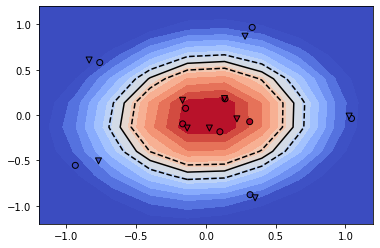

In [12]:
# 创建进度条，并设置所需要的量子核函数计算数量 N
pbar = tqdm(total=100, 
            desc='计算 PQK-SVM 决策函数中', 
            bar_format=bar_format_string)
N = 2 * 10 ** 2 * len(X_train)
    
# 可视化决策函数平面
visualize_decision_bound(svm_pqk)
pbar.close()

## 总结

在量子机器学习的研究中，研究者们希望借助量子力学的特点设计出可以超越经典机器学习方法的模型。随着该领域的研究越发深入，人们发现量子机器学习和传统机器学习可以通过核方法建立起深入的联系。相比“传统”的量子神经网络，量子核方法把研究的重点放在了从经典数据空间到量子希尔伯特空间的特征映射，而不是变分量子电路。这为量子机器学习带来了新的研究思路，并为设计出实用的量子算法带来了新的可能性。因此，我们鼓励读者一起来思考如何设计出更好的量子核函数，并将其应用在更多样的数据集上。

---

## 参考资料

[1] Schuld, Maria. "Supervised quantum machine learning models are kernel methods." arXiv preprint [arXiv:2101.11020 (2021)](https://arxiv.org/abs/2101.11020).

[2] Havlíček, Vojtěch, et al. "Supervised learning with quantum-enhanced feature spaces." [Nature 567.7747 (2019): 209-212](https://arxiv.org/abs/1804.11326).

[3] Liu, Yunchao, Srinivasan Arunachalam, and Kristan Temme. "A rigorous and robust quantum speed-up in supervised machine learning." arXiv preprint [arXiv:2010.02174 (2020)](https://arxiv.org/abs/2010.02174).

[4] Schuld, Maria, and Nathan Killoran. "Quantum machine learning in feature Hilbert spaces." [Phys. Rev. Lett. 122.4 (2019): 040504](https://arxiv.org/abs/1803.07128).

[5] Hubregtsen, Thomas, et al. "Training Quantum Embedding Kernels on Near-Term Quantum Computers." arXiv preprint [arXiv:2105.02276(2021)](https://arxiv.org/abs/2105.02276).

[6] Glick, Jennifer R., et al. "Covariant quantum kernels for data with group structure." arXiv preprint [arXiv:2105.03406(2021)](https://arxiv.org/abs/2105.03406).

[7] Huang, Hsin-Yuan, et al. "Power of data in quantum machine learning." arXiv preprint [arXiv:2011.01938 (2020)](https://arxiv.org/abs/2011.01938).

[8] Schölkopf, Bernhard, and Alexander J. Smola"Learning with kernels: support vector machines, regularization, optimization, and beyond." [MIT Press(2002)](https://mitpress.mit.edu/books/learning-kernels).